# Trabajo practico: Prediccion de lluvia Australia

Alumnos: Noir Nicolas, González Ignacio

Año: 2024

Materia: Aprendizaje automático 1

Carrera: TUIA

## Librerias

In [1]:
#!pip install scikit-learn
#!pip install pandas
#!pip install matplotlib
#!pip install seaborn
#!pip install plotly

In [2]:
import pandas as pd
from sklearn.impute import KNNImputer
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import DataConversionWarning
from sklearn import metrics
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import jaccard_score
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics.cluster import fowlkes_mallows_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression


# Libreria necesaria para poder ocultar errores que empeoran la visualización del notebook
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DataConversionWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
pd.options.mode.chained_assignment = None


## Introducción
En este trabajo vamos a crear un modelo de clasificación para la predicción de la lluvia al día siguiente en Australia en 10 ciudades elegidas al azar.

Para esto necesitaremos hacer ciertos análisis, escalados, imputados, etc., los cuales vamos a presentar brevemente a continuación (en el código va a ser explicado y justificado):

Primero necesitamos importar el dataset. Como este tiene más de 10 ciudades de Australia, haremos una selección al azar con sample y reduciremos el dataset a los datos que sean de esas ciudades. El siguiente paso es dropear todos los registros que tengan un valor faltante en la variable explicativa, después chequearemos y eliminaremos filas duplicadas. Una vez hecho esta pequeña limpieza inicial, dividimos el dataset en train y test, siendo 80/20 la proporción. También tendremos que dividirlo de manera que en el punto donde se divida para atrás en fecha sea entrenamiento y para adelante sea prueba. A continuación analizaremos los valores faltantes de x_train, decidiendo qué filas son dropeadas por la cantidad de valores faltantes. Lo siguiente es el análisis de las distribuciones, correlaciones, tipos de datos, outliers, medias, medianas, etc.
Después codificamos las variables categóricas y cíclicas para poder imputar valores faltantes mediante MICE con LinearRegression o Interpolación. Una vez imputados los valores faltantes, corregimos los valores erróneos, que pueden ser valores negativos o fuera de la escala/rango o fuera de su tipo de dato. Por ejemplo, en el caso de Rainfall no puede haber lluvia negativa. El siguiente paso es decodificar las variables Location y las direcciones del viento, ya que fueron codificadas con ordinal encoder para su posible uso en la imputación. Ahora es necesario devolverlos a su forma original y codificarlos de nuevo para que sean utilizables en la regresión logística. Pasamos a la creación de los modelos de clasificación, donde haremos 4 modelos de clasificación. Uno por cada tipo de método de imputación y a su vez uno por cada valor del parámetro de class_weight de LogisticRegression que puede ser balanced donde imita un balanceo del dataset o default en el que se usa la regresión logística con los datos que tenemos, aunque estén desbalanceados. Calculamos todas las métricas de clasificación y la que vamos a elegir para comparar los modelos va a ser el recall.

## Código

### Apartado 1

In [3]:
dataset_lluvia_completo_raw = pd.read_csv('https://raw.githubusercontent.com/nacho-gonz/AA1-Archivos-2024/master/weatherAUS.csv')
ciudades_elegidas = dataset_lluvia_completo_raw["Location"].sample(10, random_state=528548).to_list()
df_ciudad = dataset_lluvia_completo_raw[dataset_lluvia_completo_raw["Location"].isin(ciudades_elegidas)]
df_ciudad.dropna(subset=['RainTomorrow'], inplace=True)

df_ciudad_ord = df_ciudad.sort_values(by='Date')

Importamos el dataset y elegimos 10 ciudades la azar, dropeamos todas las filas que tengan valores faltantes en la variable target y ordenamos el dataset. Esto para que no haya fuga de datos entre train y test, ya que al ser una serie de tiempo necesito que todos los días del conjunto de test no esten mezclados en train.

In [4]:
x_train, x_test, y_train, y_test = train_test_split(df_ciudad_ord.drop("RainTomorrow", axis=1), df_ciudad_ord['RainTomorrow'].values.reshape(-1,1), shuffle=False, test_size=0.2, random_state=28869)

In [5]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((23095, 22), (5774, 22), (23095, 1), (5774, 1))

In [6]:
valores_faltantes = x_train[x_train.isna().any(axis=1)]
valores_faltantes.shape

(11697, 22)

Vemos que hay muchas filas con valores faltantes, el 50% de los datos, esto descarta la posibilidad de dropear todas las filas con valores faltantes, ya que supera el 5% de los datos. Además en una serie de tiempo es necesario tener un análisis más profundo de estos datos faltantes, ya que podría estar sesgando mi modelo por no poder descubrir patrones al quitar estos valores faltantes.

In [7]:
valores_faltantes.isna().sum(axis=0)

Date                0
Location            0
MinTemp           252
MaxTemp           148
Rainfall          238
Evaporation      9876
Sunshine         8173
WindGustDir      2995
WindGustSpeed    2978
WindDir9am       2185
WindDir3pm       1070
WindSpeed9am      465
WindSpeed3pm      632
Humidity9am       255
Humidity3pm       385
Pressure9am      5028
Pressure3pm      5033
Cloud9am         5292
Cloud3pm         5882
Temp9am           173
Temp3pm           343
RainToday         238
dtype: int64

Vemos cuales son las columnas con mayor cantidad de datos faltantes (Evaporation, Sunshine, Cloud3pm, Cloud9am), menor cantidad valores faltantes (RainFall, RainToday, Temp) y ausencia de valores faltantes (Date, Location). 

In [8]:
valores_faltantes.isna().sum(axis=1).value_counts(sort=True)

6     3321
1     2451
4     1614
2     1277
3     1077
7      813
11     315
8      293
5      183
12     177
9       39
17      37
18      28
13      28
10      15
19      10
14      10
15       4
20       4
16       1
Name: count, dtype: int64

Observamos la cantidad de filas que tienen diferentes cantidad de valores faltantes. 

In [9]:
x_train_compl = x_train.copy()
x_train_compl['RainTomorrow'] = y_train.flatten()
x_train_compl.dropna(thresh=8, inplace=True)

y_train_modif = x_train_compl['RainTomorrow']
x_train_modif = x_train_compl.drop(columns='RainTomorrow')
y_train_codif = pd.get_dummies(y_train_modif, drop_first=True)
y_test_codif = pd.get_dummies(y_test.flatten(), drop_first=True)

In [10]:
x_train_modif.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23015 entries, 45587 to 17530
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           23015 non-null  object 
 1   Location       23015 non-null  object 
 2   MinTemp        22842 non-null  float64
 3   MaxTemp        22904 non-null  float64
 4   Rainfall       22792 non-null  float64
 5   Evaporation    13219 non-null  float64
 6   Sunshine       14917 non-null  float64
 7   WindGustDir    20099 non-null  object 
 8   WindGustSpeed  20116 non-null  float64
 9   WindDir9am     20910 non-null  object 
 10  WindDir3pm     22025 non-null  object 
 11  WindSpeed9am   22630 non-null  float64
 12  WindSpeed3pm   22463 non-null  float64
 13  Humidity9am    22840 non-null  float64
 14  Humidity3pm    22710 non-null  float64
 15  Pressure9am    18067 non-null  float64
 16  Pressure3pm    18062 non-null  float64
 17  Cloud9am       17803 non-null  float64
 18  Cloud3p

In [11]:
print(x_train_modif.groupby('Location').describe().transpose().to_string())

Location                Brisbane     Canberra        Moree    Newcastle         Nhil    Nuriootpa   PearceRAAF        Perth         Sale   SalmonGums
MinTemp       count  2580.000000  2829.000000  2290.000000  2186.000000   985.000000  2409.000000  2165.000000  2608.000000  2420.000000  2370.000000
              mean     16.108333     6.591622    12.407467    13.422049     8.497868     9.246866    12.387252    12.834164     8.332479     9.276287
              std       4.635506     6.233339     6.786552     5.000512     4.958333     5.048927     5.301746     5.131978     4.900524     5.483400
              min       2.600000    -8.000000    -3.300000     2.200000    -2.300000    -3.500000    -1.900000    -0.600000    -3.900000    -4.400000
              25%      12.500000     1.600000     6.600000     9.400000     5.000000     5.800000     8.700000     9.100000     4.700000     5.300000
              50%      16.400000     6.700000    13.000000    13.500000     8.000000     8.900000   

Observamos todas las medidas descriptivas de cada variable por localidad. 

En MinTemp podemos ver que hay diferencias significativas entre las medianas de las localidades. Viendo MinTemp y MaxTemp puedo interpretar que al haber ciudades con temperaturas mínimas muy bajas y temperaturas máximas muy altas, estariamos hablando de ciudades con climas deserticos, además las temperaturas de 9am y 3pm me dan sustento en la ídea, ya que estas mismas ciudades varían sus temperaturas abruptamente en estos tiempos.

En MaxTemp no se ven diferencias significativas entre las medianas de las localidades.

En RainFall no se ven diferencias entre las medianas de las localidades. Si observamos el percentil 75, nos agrega información sobre la anterior hipótesis donde si su percentil 75 sigue siendo un valor muy cercano a 0, esta ciudad no tiene lluvias en general y concuerda con las ciudades de climas deserticos.

En Evaporation no se ven diferencias significativas entre las medianas de las localidades. Además se observa que 4 de estas ciudades no tienen valores medidos para esta variable.

En Sunshise se ven diferencias significativas entre las medianas de las localidades. 

En WindGustSpeed

In [12]:
# graficar_valores = x_train_compl[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
#       'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
#       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
#       'Temp3pm','RainTomorrow']]

# fig, axes = plt.subplots(8,2)

# for name, ax in zip(graficar_valores, axes.flatten()):
#    sns.boxplot(x=name, data=graficar_valores, orient='h', ax=ax, hue='RainTomorrow')

# fig.set_size_inches(18,28)
# plt.tight_layout()
# plt.show()

In [13]:
# fig2, axes2 = plt.subplots(8,2)

# for name, ax in zip(graficar_valores, axes2.flatten()):
#    if name == "Rainfall":
#        sns.histplot(x=name, data=graficar_valores, ax=ax,kde=True, bins=70, hue='RainTomorrow')
#    else:
#        sns.histplot(x=name, data=graficar_valores, ax=ax,kde=True, hue='RainTomorrow')

# fig2.set_size_inches(18,28)
# plt.tight_layout()
# plt.show()

In [14]:
#sns.pairplot(graficar_valores, hue='RainTomorrow', corner=True)
#plt.show()

In [15]:
#vientos = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainTomorrow']
#
#fig, axes = plt.subplots(2,2)
#
#for name, ax in zip(vientos, axes.flatten()):
#    sns.countplot(y=name, data=x_train_compl[vientos], orient='h', ax=ax, hue='RainTomorrow')
#    if name  == 'WindGustDir':
#        ax.title.set_text('Frecuancia de las direcicones de las rafagas de vientos')
#    if name == 'WindDir9am':
#        ax.title.set_text('Frecuancia de las direcicones del viento a las 9am')
#    if name == 'WindDir3pm':
#        ax.title.set_text('Frecuancia de las direcicones del viento a las 3am')
#    else:
#        ax.title.set_text('Frecuencia de las precipitaciones al dia siguiente')
#
#fig.set_size_inches(18,14)
#plt.tight_layout()
#plt.show()

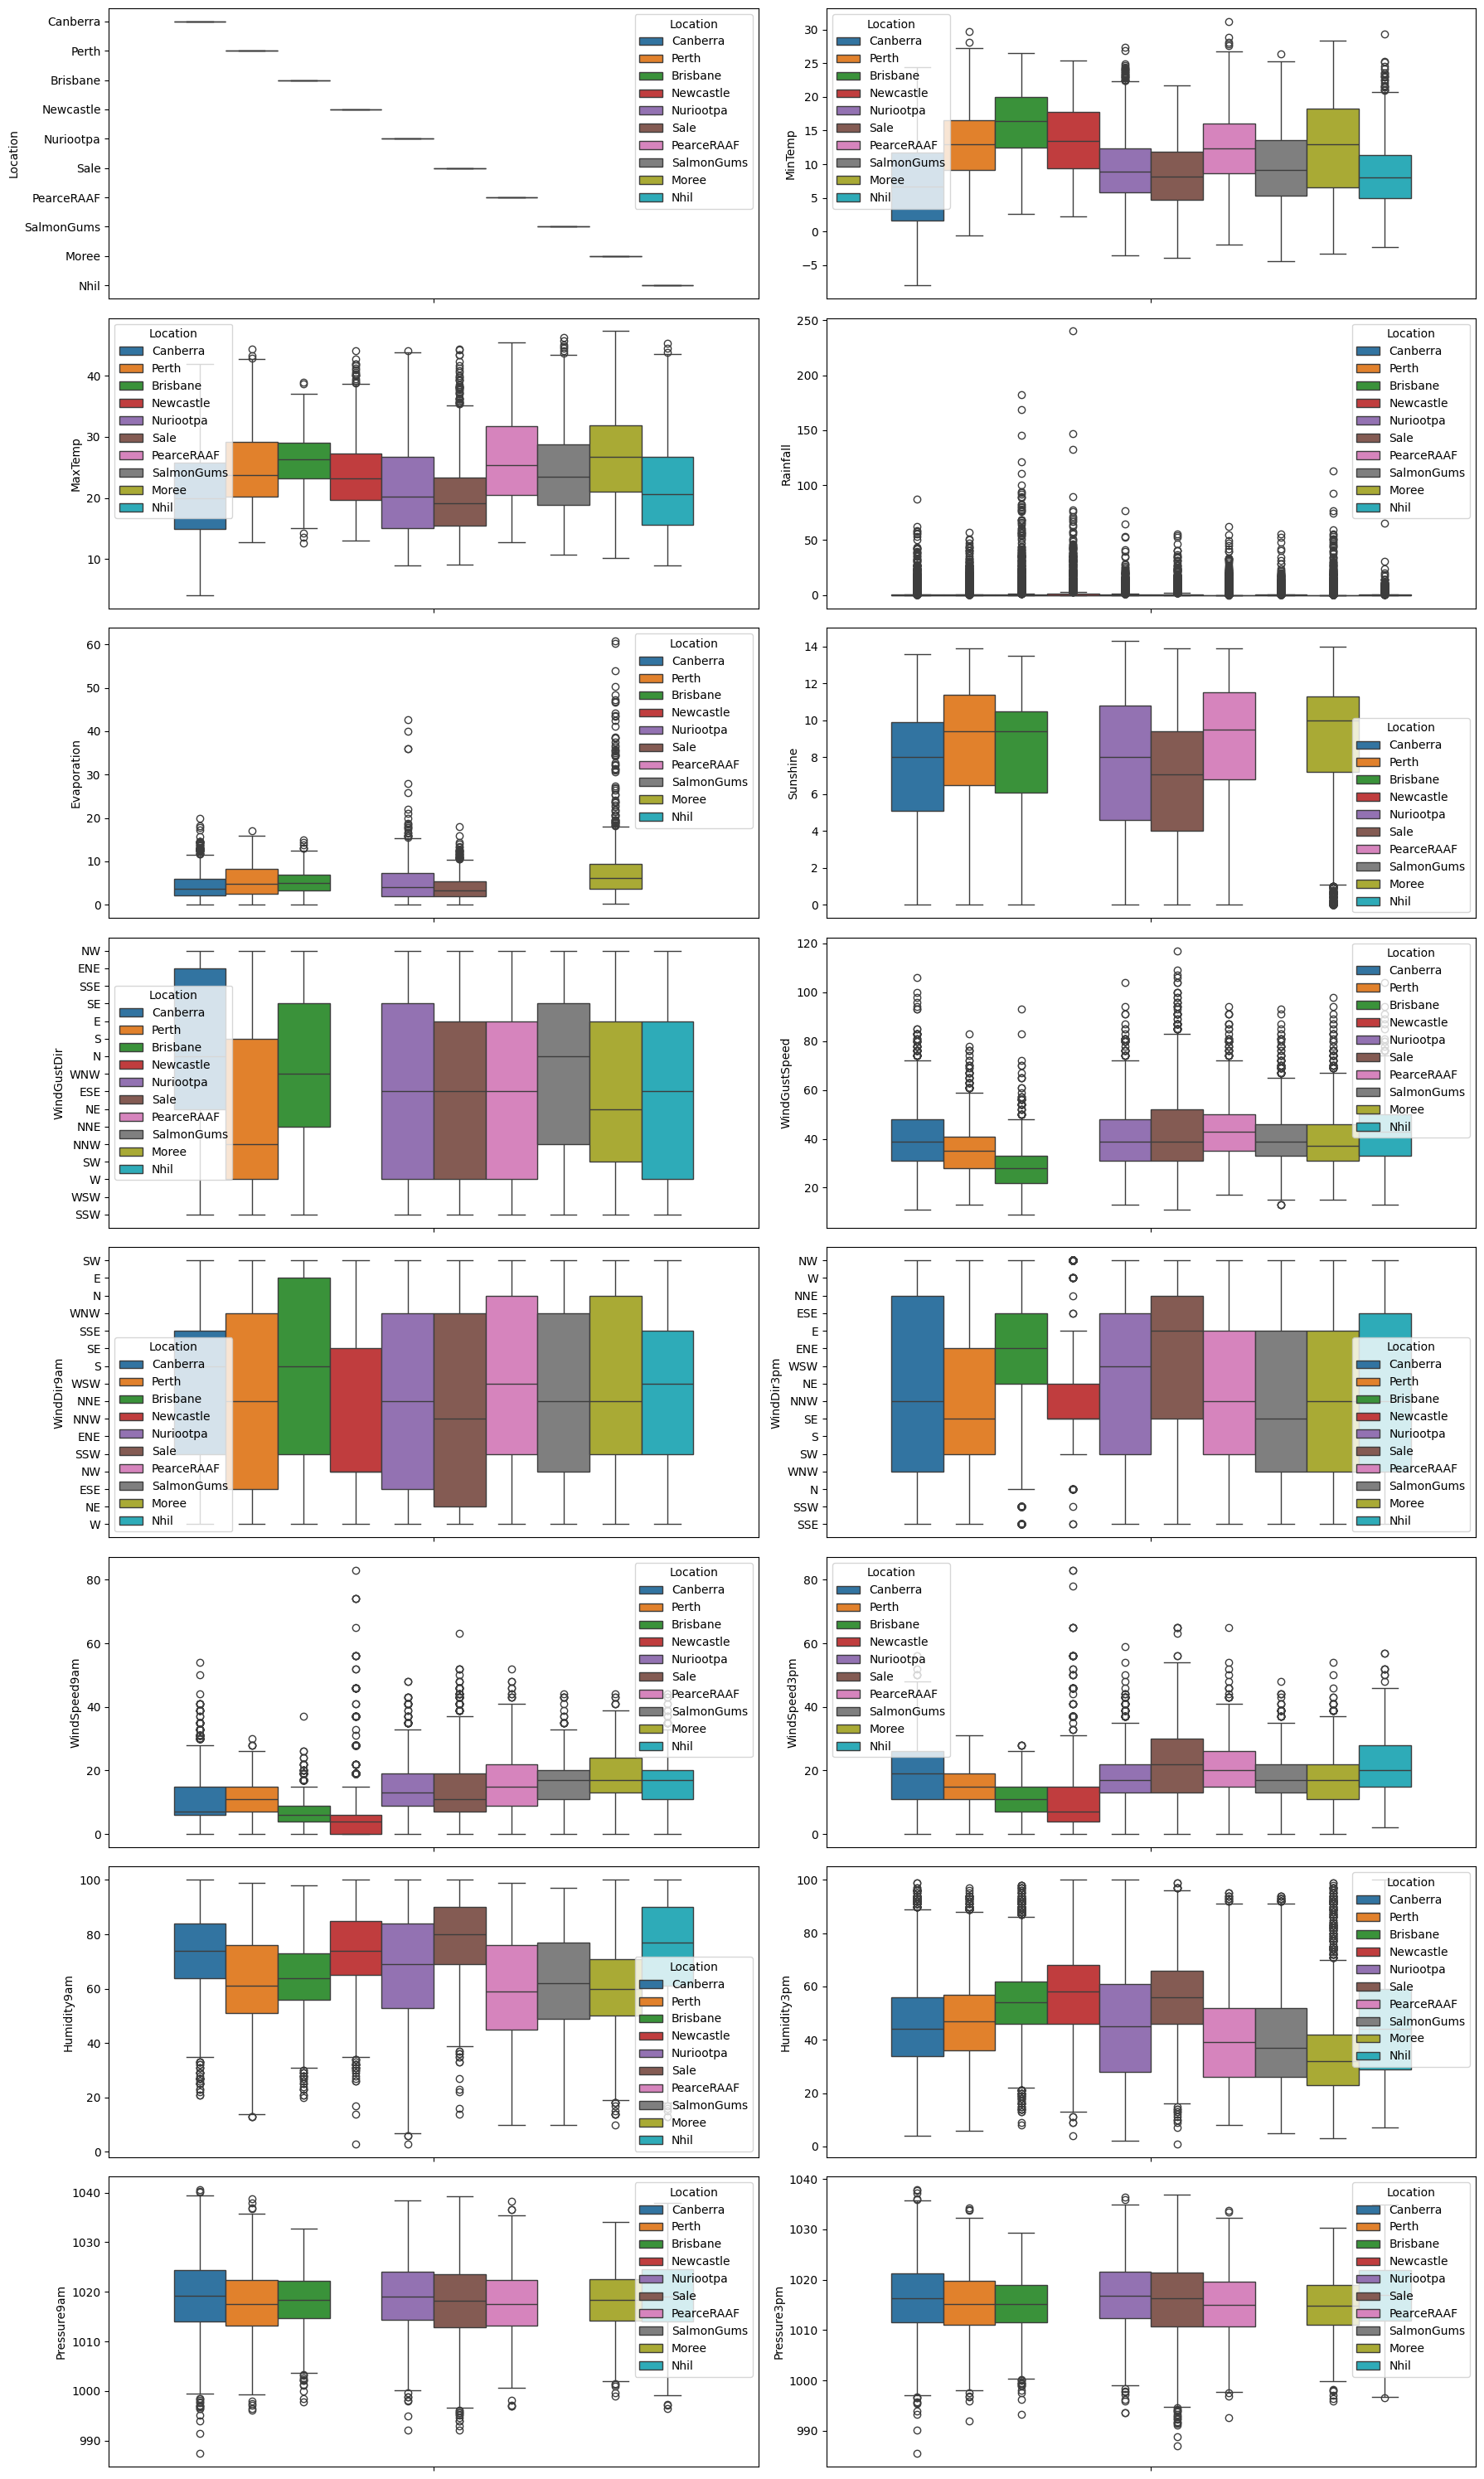

In [16]:
localidades = x_train_modif[['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
    'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
    'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
    'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
    'Temp3pm', 'RainToday']]

fig, axes = plt.subplots(8,2)

for name, ax in zip(localidades, axes.flatten()):
    sns.boxplot(y=name, data=localidades, orient='v', ax=ax, hue='Location')

fig.set_size_inches(18,30)
plt.tight_layout()
plt.show()
    

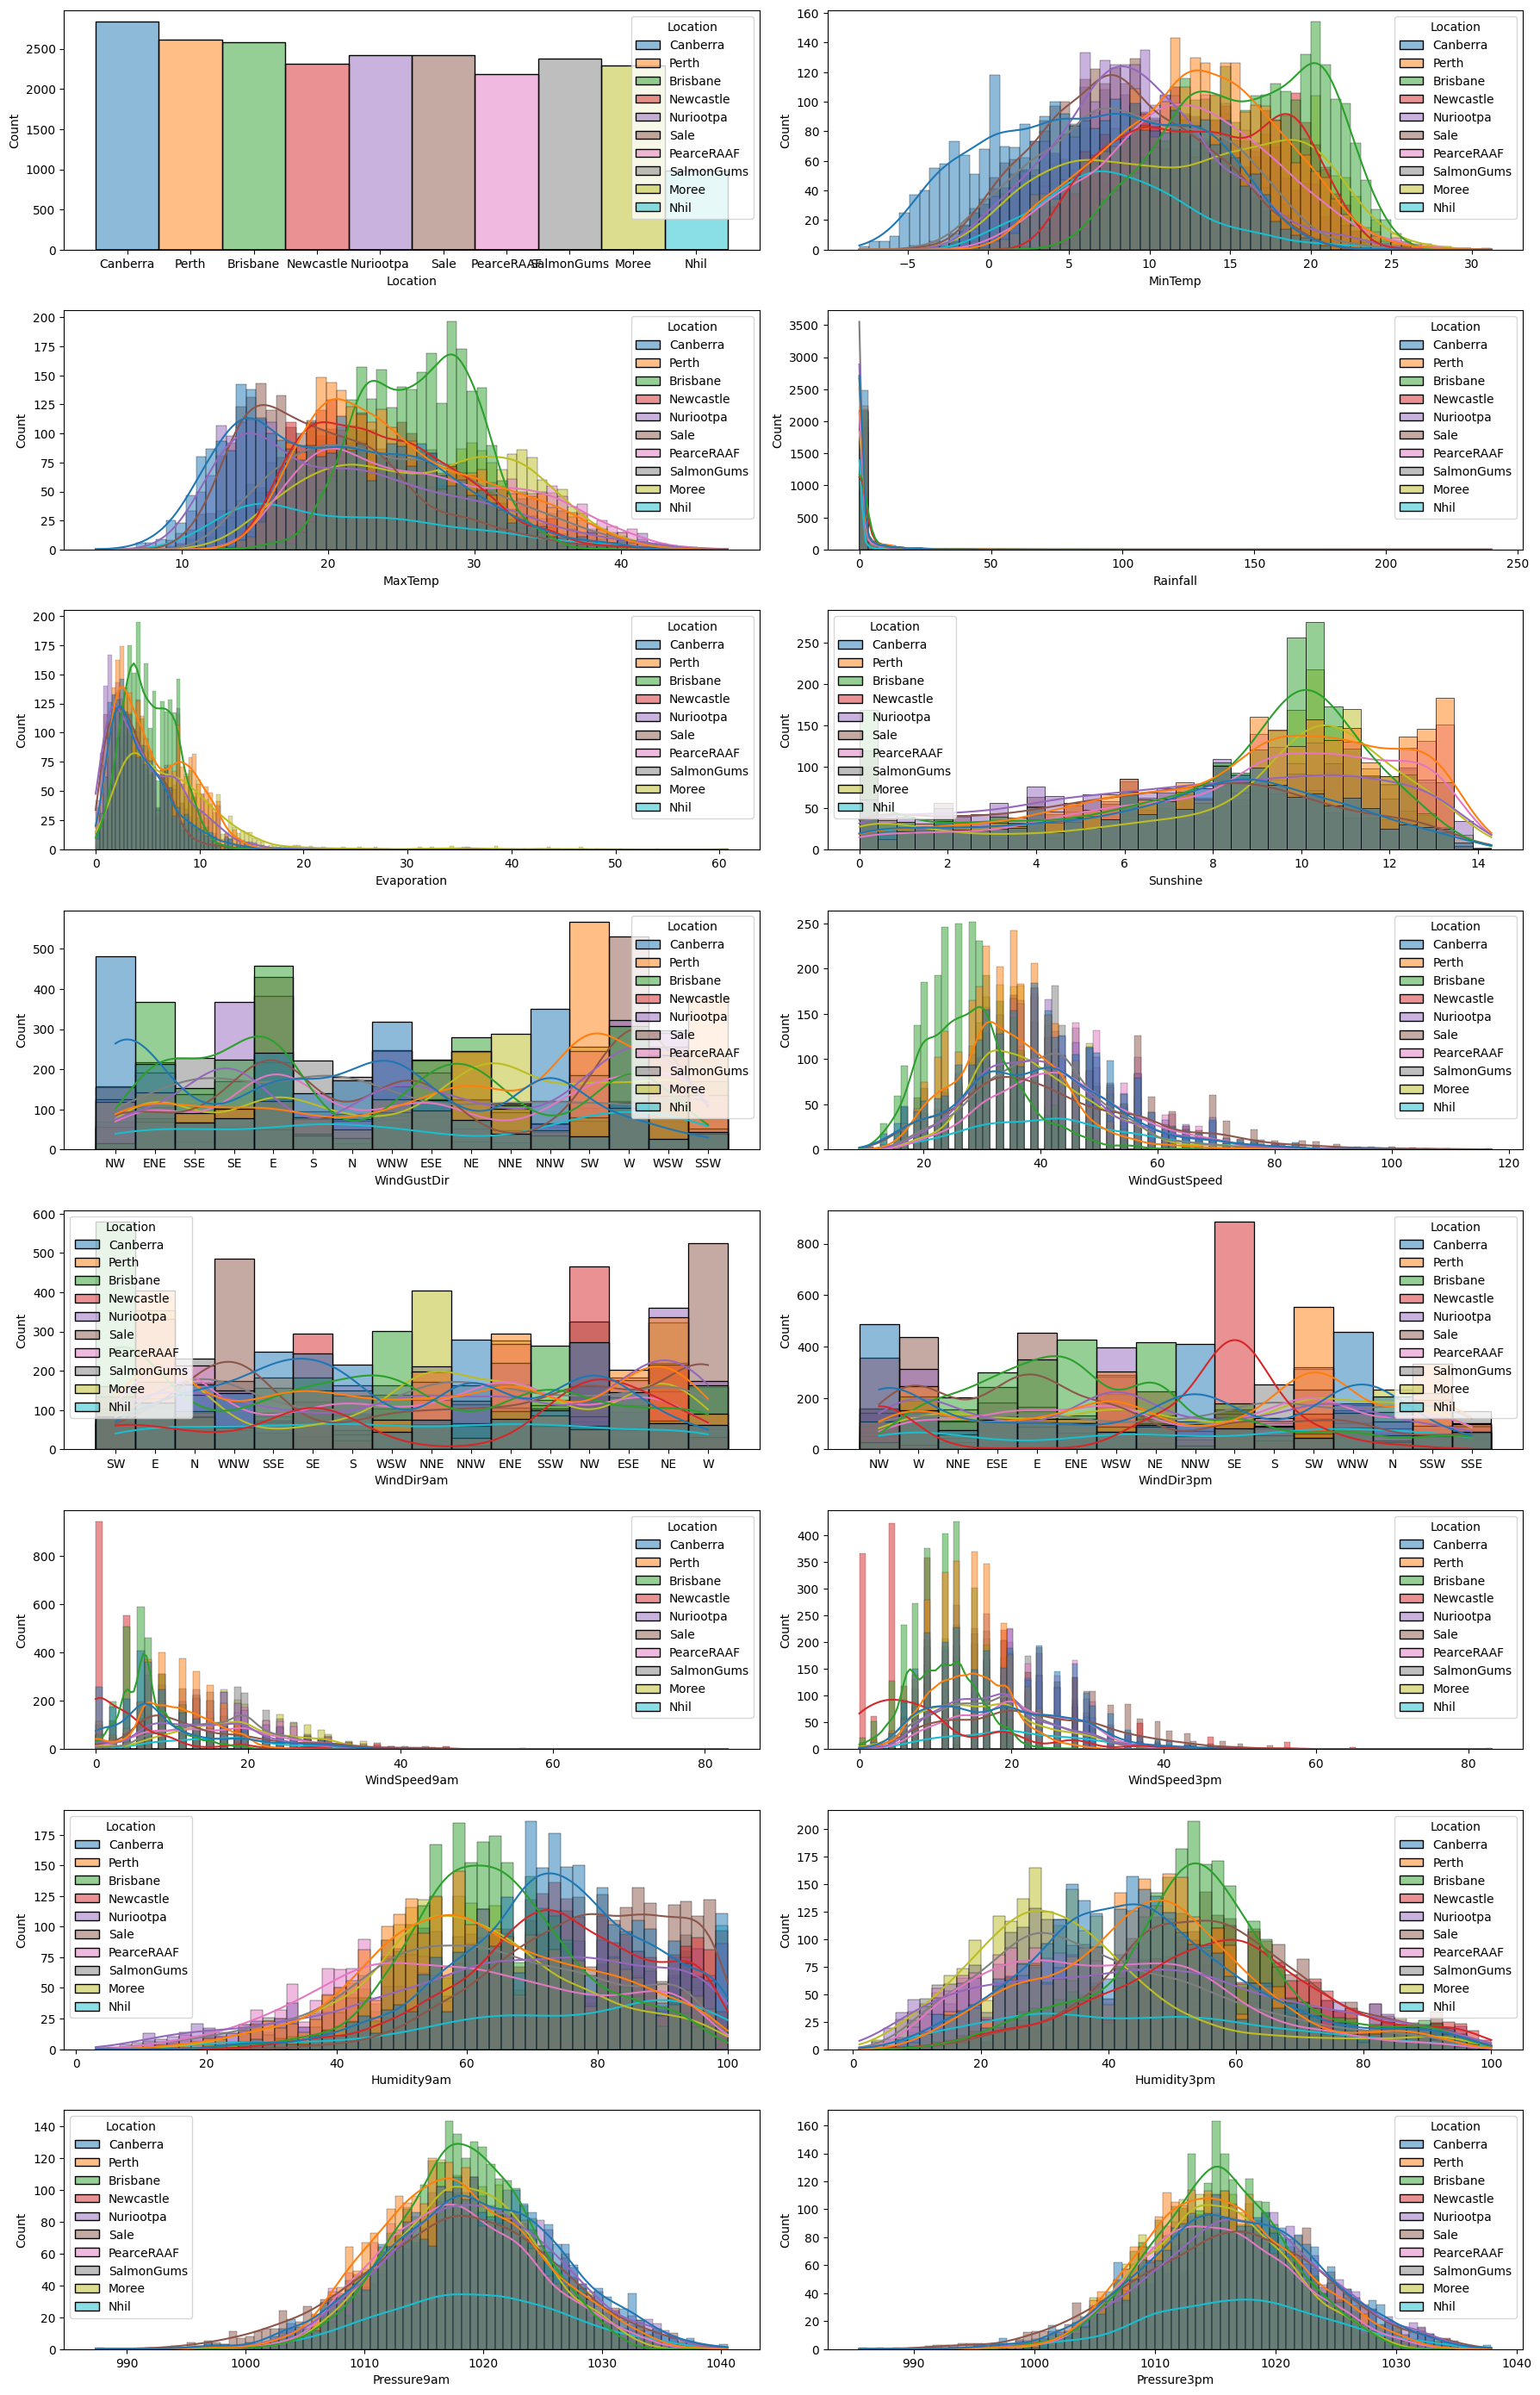

In [17]:
fig2, axes2 = plt.subplots(8,2)

for name, ax in zip(localidades, axes2.flatten()):
    if name == "Rainfall":
        sns.histplot(x=name, data=localidades, ax=ax,kde=True, bins=70, hue='Location')
    else:
        sns.histplot(x=name, data=localidades, ax=ax,kde=True, hue='Location')

fig2.set_size_inches(18,28)
plt.tight_layout()
plt.show()

In [18]:
x_train_compl['RainTomorrow'].value_counts()

RainTomorrow
No     18575
Yes     4440
Name: count, dtype: int64

El dataset no esta balanceado. 

Porque en algun momento se nos va a pedir que se tome una decision en base al balanceo del dataset, siendo undersampling u oversampling en sus diferentes formas o methodos.

---

In [19]:
puntos_8 = {'NNE': 'NE', 'ENE': 'E', 'ESE': 'SE', 'SSE':'S', 'SSW': 'SW', 'WSW': 'W', 'WNW': 'NW', 'NNW': 'N'}

x_train_modif['WindGustDir'] = x_train_modif['WindGustDir'].replace(puntos_8)
x_train_modif['WindDir9am'] = x_train_modif['WindDir9am'].replace(puntos_8)
x_train_modif['WindDir3pm'] = x_train_modif['WindDir3pm'].replace(puntos_8)

x_test['WindGustDir'] = x_test['WindGustDir'].replace(puntos_8)
x_test['WindDir9am'] = x_test['WindDir9am'].replace(puntos_8)
x_test['WindDir3pm'] = x_test['WindDir3pm'].replace(puntos_8)

Reemplazamos los puntos cardinales de las columnas WindGustDir, WindDir9am y WindDir3pm, que son 16, por los 8 puntos cardinales principales, rotando todos los ejes en sentido horario, pasando NNE a NE, de ENE a E, y así sucesivamente, para ambos conjuntos de datos (train y test

In [20]:
x_train_modif['Date'] = pd.to_datetime(x_train_modif['Date'])
x_train_modif['week_year'] = x_train_modif['Date'].dt.strftime('%U')

x_test['Date'] = pd.to_datetime(x_test['Date'])
x_test['week_year'] = x_test['Date'].dt.strftime('%U')

enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1).set_output(transform='pandas')

enc.fit(x_train_modif[['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']])


x_train_modif[['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']] = enc.transform(x_train_modif[['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']])

x_test[['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']] = enc.transform(x_test[['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']])

x_train_modif['week_year'] = x_train_modif['week_year'].astype(int)

x_test['week_year'] = x_test['week_year'].astype(int)

x_train_modif.index = x_train_modif['Date']
x_test.index = x_test['Date']


x_train_modif.drop('Date', axis=1, inplace=True)
x_test.drop('Date', axis=1, inplace=True)

In [21]:
x_train_codif = pd.get_dummies(data=x_train_modif ,columns=["RainToday"], drop_first=True)
x_test_codif = pd.get_dummies(data=x_test, columns=["RainToday"], drop_first=True)

In [22]:
x_train_codif['Location']

Date
2007-11-01    1.0
2007-11-02    1.0
2007-11-03    1.0
2007-11-04    1.0
2007-11-05    1.0
             ... 
2015-11-18    8.0
2015-11-18    0.0
2015-11-18    4.0
2015-11-18    5.0
2015-11-18    3.0
Name: Location, Length: 23015, dtype: float64

In [23]:
x_train_interpol_imp = x_train_codif.interpolate(method='time', axis=0)
x_test_interpol_imp = x_test_codif.interpolate(method='time', axis=0)

In [24]:
reg = LinearRegression()

imp_mean = IterativeImputer(estimator=reg, initial_strategy='median',imputation_order='roman' ,random_state=120931).set_output(transform='pandas')
x_train_iterative_imputer = imp_mean.fit_transform(x_train_codif)
x_test_iterative_imputer = imp_mean.transform(x_test_codif)

In [25]:
x_train_interpol_imp.describe()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,week_year
count,23015.000000,23015.000000,23015.000000,23015.000000,23015.000000,23015.000000,23015.000000,23015.000000,23015.000000,23015.00000,...,23015.000000,23015.000000,23015.000000,23015.000000,23015.000000,23015.000000,23015.000000,23015.000000,23015.000000,23015.000000
mean,4.452748,10.983267,23.633817,1.877358,5.383337,8.162546,3.641017,38.681599,3.270541,3.85277,...,16.939431,67.428807,46.831936,1018.350628,1015.779283,4.091592,4.225027,16.713748,22.133787,26.163937
std,2.994102,6.135325,6.735707,6.914445,4.073631,3.628185,2.474644,12.917472,2.318198,2.36623,...,8.965965,18.303465,19.375794,6.834358,6.619121,2.893168,2.675747,6.104752,6.576377,14.750706
min,0.000000,-8.000000,4.100000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.00000,...,0.000000,3.000000,1.000000,987.400000,985.500000,0.000000,0.000000,-1.300000,3.700000,0.000000
25%,2.000000,6.600000,18.600000,0.000000,2.600000,5.800000,1.000000,30.000000,1.000000,2.00000,...,11.000000,55.000000,32.000000,1013.700000,1011.300000,1.000000,2.000000,12.300000,17.200000,13.000000
50%,5.000000,11.000000,23.100000,0.000000,4.600000,9.100000,4.000000,37.000000,3.000000,4.00000,...,15.000000,68.000000,46.000000,1018.300000,1015.600000,4.000000,4.000000,16.500000,21.700000,27.000000
75%,7.000000,15.500000,28.400000,0.400000,7.400000,10.900000,6.000000,46.000000,5.000000,6.00000,...,22.000000,81.000000,59.000000,1023.000000,1020.200000,7.000000,7.000000,21.100000,26.700000,39.000000
max,9.000000,31.200000,47.300000,240.000000,60.800000,14.300000,7.000000,117.000000,7.000000,7.00000,...,83.000000,100.000000,100.000000,1040.600000,1037.900000,9.000000,8.000000,40.200000,45.800000,52.000000


In [26]:
def positivisar(df):

    variables = [ 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Cloud9am', 'Cloud3pm']

    columnas = df.columns
    for col in columnas:
        if col in ['MinTemp','MaxTemp','Temp9am','Temp3pm']:
            continue
        df[col][df[col] < 0] = 0
        df[col] = df[col].round(1)
        if col in variables:
            df[col] = df[col].astype(int)
        if col in ['Cloud9am', 'Cloud3pm']:
            df[col] = df[col].replace([9, 10], 8) 
    return df

Usamos esta función de 'positivizar' variables, ya que nuestro imputador de valores faltantes (Iterativeimputer), imputa valores negativos en variables donde no pueden existir valores negativos, como en el caso de Rainfall, que sabemos que no puede existir lluvia negativa, y por eso transformamos los valores negativos a 0

Para los casos específicos de 'Cloud9am' y 'Cloud3pm', sabemos que el rango de sus valores son los números naturales positivos de 0 a 8, o sea, que se mide en octavos de cielo cubierto, donde 0 octas representa el cielo despejado y 8 representa el cielo cubierto, por eso para los valores mayores a 8, los redondeamos a 8 y los valores menores a 1, los redondeamos en 1.

In [27]:
x_train_iterative_imputer_pos = positivisar(x_train_iterative_imputer)
x_test_iterative_imputer_pos = positivisar(x_test_iterative_imputer)

x_train_interpol_imputer_pos = positivisar(x_train_interpol_imp)
x_test_interpol_imputer_pos = positivisar(x_test_interpol_imp)

In [28]:
x_train_iterative_imputer_pos.describe()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,week_year,RainToday_Yes
count,23015.000000,23015.00000,23015.000000,23015.000000,23015.000000,23015.000000,23015.000000,23015.000000,23015.000000,23015.000000,...,23015.000000,23015.000000,23015.000000,23015.000000,23015.000000,23015.000000,23015.000000,23015.000000,23015.000000,23015.000000
mean,4.452748,11.00044,23.636873,1.872179,5.222924,8.053748,3.597828,37.614860,3.266696,3.821855,...,67.470736,46.931219,1018.468720,1015.909841,3.828025,3.983532,16.716140,22.133359,26.163937,0.191049
std,2.994102,6.12983,6.730105,6.901114,3.473211,3.509694,2.345564,13.083833,2.226321,2.324295,...,18.290984,19.364024,6.187692,5.974068,2.759621,2.489857,6.101905,6.563901,14.750706,0.393136
min,0.000000,-8.00000,4.100000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,...,3.000000,1.000000,987.400000,985.500000,0.000000,0.000000,-1.300000,3.700000,0.000000,0.000000
25%,2.000000,6.60000,18.600000,0.000000,2.800000,5.600000,2.000000,28.000000,2.000000,2.000000,...,55.000000,32.000000,1014.800000,1012.400000,1.000000,2.000000,12.300000,17.200000,13.000000,0.000000
50%,5.000000,11.00000,23.100000,0.000000,4.700000,8.700000,4.000000,36.000000,3.000000,4.000000,...,68.000000,47.000000,1018.500000,1015.900000,4.000000,4.000000,16.500000,21.700000,27.000000,0.000000
75%,7.000000,15.50000,28.400000,0.400000,7.200000,10.700000,6.000000,44.000000,5.000000,6.000000,...,81.000000,59.000000,1022.100000,1019.300000,7.000000,6.000000,21.100000,26.700000,39.000000,0.000000
max,9.000000,31.20000,47.300000,240.000000,60.800000,17.800000,7.000000,123.000000,7.000000,7.000000,...,107.000000,100.000000,1040.600000,1037.900000,8.000000,8.000000,40.200000,45.800000,52.000000,1.000000


# Descodificacion de variables

In [29]:
x_train_imputer_decodif = enc.inverse_transform(x_train_iterative_imputer_pos[['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']])
x_test_imputer_decodif = enc.inverse_transform(x_test_iterative_imputer_pos[['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']])

Luego de codificar e imputar los valores faltantes, realizamos la operación contraria a la codificación, ya que nos interesa tener los valores de 'Location' como dummies, ya que no nos interesa tener las variables de manera ordinal, por eso la transformamos a las 9 dummies que teníamos anteriormente

Para los valores 'WindGustDir', 'WindDir9am' y 'WindDir3pm', también realizamos la decodificación, para asignarle los valores de seno y coseno que habíamos calculado anteriormente

In [30]:
x_train_index = x_train_iterative_imputer_pos.reset_index().drop('Date', axis=1)
x_train_vacio = x_train_index.drop(['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], axis=1)
x_train_decodif = pd.DataFrame(data=x_train_imputer_decodif, columns= ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'])
x_train_merge_imp = pd.merge(x_train_vacio, x_train_decodif,left_index=True, right_index=True, how='left')

x_test_index = x_test_iterative_imputer_pos.reset_index().drop('Date', axis=1)
x_test_vacio = x_test_index.drop(['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], axis=1)
x_test_decodif = pd.DataFrame(data=x_test_imputer_decodif, columns= ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'])
x_test_merge_imp = pd.merge(x_test_vacio, x_test_decodif,left_index=True, right_index=True, how='left')

En este caso sacamos las variables anteriormente decodificadas del dataset, para luego mergearlo con el dataset anterior,

In [31]:
def codificar_variables(dataset):
    """
    Codifica y reemplaza date, WindGustDir, WindDir9am, WindDir3pm, Raintoday, Location
    """
    
    dataset['sin_week'] = np.sin(2 * np.pi * dataset['week_year'] / 52)
    dataset['cos_week'] = np.cos(2 * np.pi * dataset['week_year'] / 52)
    dataset.drop('week_year', axis=1, inplace=True)

    puntos_cardinales = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W','NW']

    angulos = np.arange(0, 360, 45)
    df_angulos_cardinal = pd.DataFrame({'puntos': puntos_cardinales, 'angulos': angulos})
    
    dataset_ang = dataset.merge(df_angulos_cardinal, left_on='WindGustDir', right_on=['puntos'], how='left')
    dataset_ang = dataset.merge(df_angulos_cardinal, left_on='WindDir9am', right_on=['puntos'], how='left')
    dataset_ang = dataset.merge(df_angulos_cardinal, left_on='WindDir3pm', right_on=['puntos'], how='left')

    dataset_ang['sin_WindGustDir'] = round(np.sin(2 * np.pi * dataset_ang['angulos'] / 360), ndigits=4)
    dataset_ang['cos_WindGustDir'] = round(np.cos(2 * np.pi * dataset_ang['angulos'] / 360), ndigits=4)

    dataset_ang['sin_WindDir9am'] = round(np.sin(2 * np.pi * dataset_ang['angulos'] / 360), ndigits=4)
    dataset_ang['cos_WindDir9am'] = round(np.cos(2 * np.pi * dataset_ang['angulos'] / 360), ndigits=4)

    dataset_ang['sin_WindDir3pm'] = round(np.sin(2 * np.pi * dataset_ang['angulos'] / 360), ndigits=4)
    dataset_ang['cos_WindDir3pm'] = round(np.cos(2 * np.pi * dataset_ang['angulos'] / 360), ndigits=4)

        
    dataset_ang.drop('WindGustDir', axis=1, inplace=True)
    dataset_ang.drop('WindDir9am', axis=1, inplace=True)
    dataset_ang.drop('WindDir3pm', axis=1, inplace=True)

    dataset_ang.drop('angulos', axis=1, inplace=True)
    dataset_ang.drop('puntos', axis=1, inplace=True)
    
    dataset_codificado = pd.get_dummies(dataset_ang, columns=['Location'], drop_first=True)
    return dataset_codificado

En esta celda de código estamos buscando codificar las variables de Date, Location, WindGustDir, WindDir9am y WindDir3pm. 

Cambiamos los tipos de fecha, que ya habíamos codificado anteriormente de fecha a semanas del año, ahora lo que buscamos, es darle una verdadera distancia entre semanas, ya que la última semana de diciembre (semana 52) está muy cerca de la primera semana de enero (semana 1), pero esto no puede ser plasmado con el tipo de codificación que tenemos de 1 a 52, por lo tanto, pensamos en implementar un sistema trigonométrico, donde ahora si se podrá representar una verdadera relación de distancia entre cada semana, realizando una para el coseno y otra para el seno, ya que si nos quedáramos con una única, estos datos, de forma única, serían erróneos.

Con WindGustDir, WindDir9am y WindDir3pm, pensamos algo similar, anteriormente reduciendo los 16 puntos cardinales a 8, ahora para darle un sistema de cercanía real, utilizamos el mismo sistema trigonométrico que con las fechas, pero ahora asignándole a cada punto cardinal un grado. Al ser 8, dividimos 8 sobre 360, dándonos que existe una separación de 45 grados entre cada punto cardinal, como se estipula para los puntos cardinales en la realidad

Con Location realizamos dummies, ya que no podemos plantear la distancia entre cada ciudad y tampoco podemos darle un valor ordinal, ya que una ciudad no es mayor o menor a otra, y esto realizaría que nuestro modelo de valores erróneos o sesgados

In [32]:
x_train_procesado = codificar_variables(x_train_merge_imp)
x_test_procesado = codificar_variables(x_test_merge_imp)

In [33]:
df_train_completo = x_train_procesado.copy()
df_train_completo['RainTomorrow'] = y_train_codif

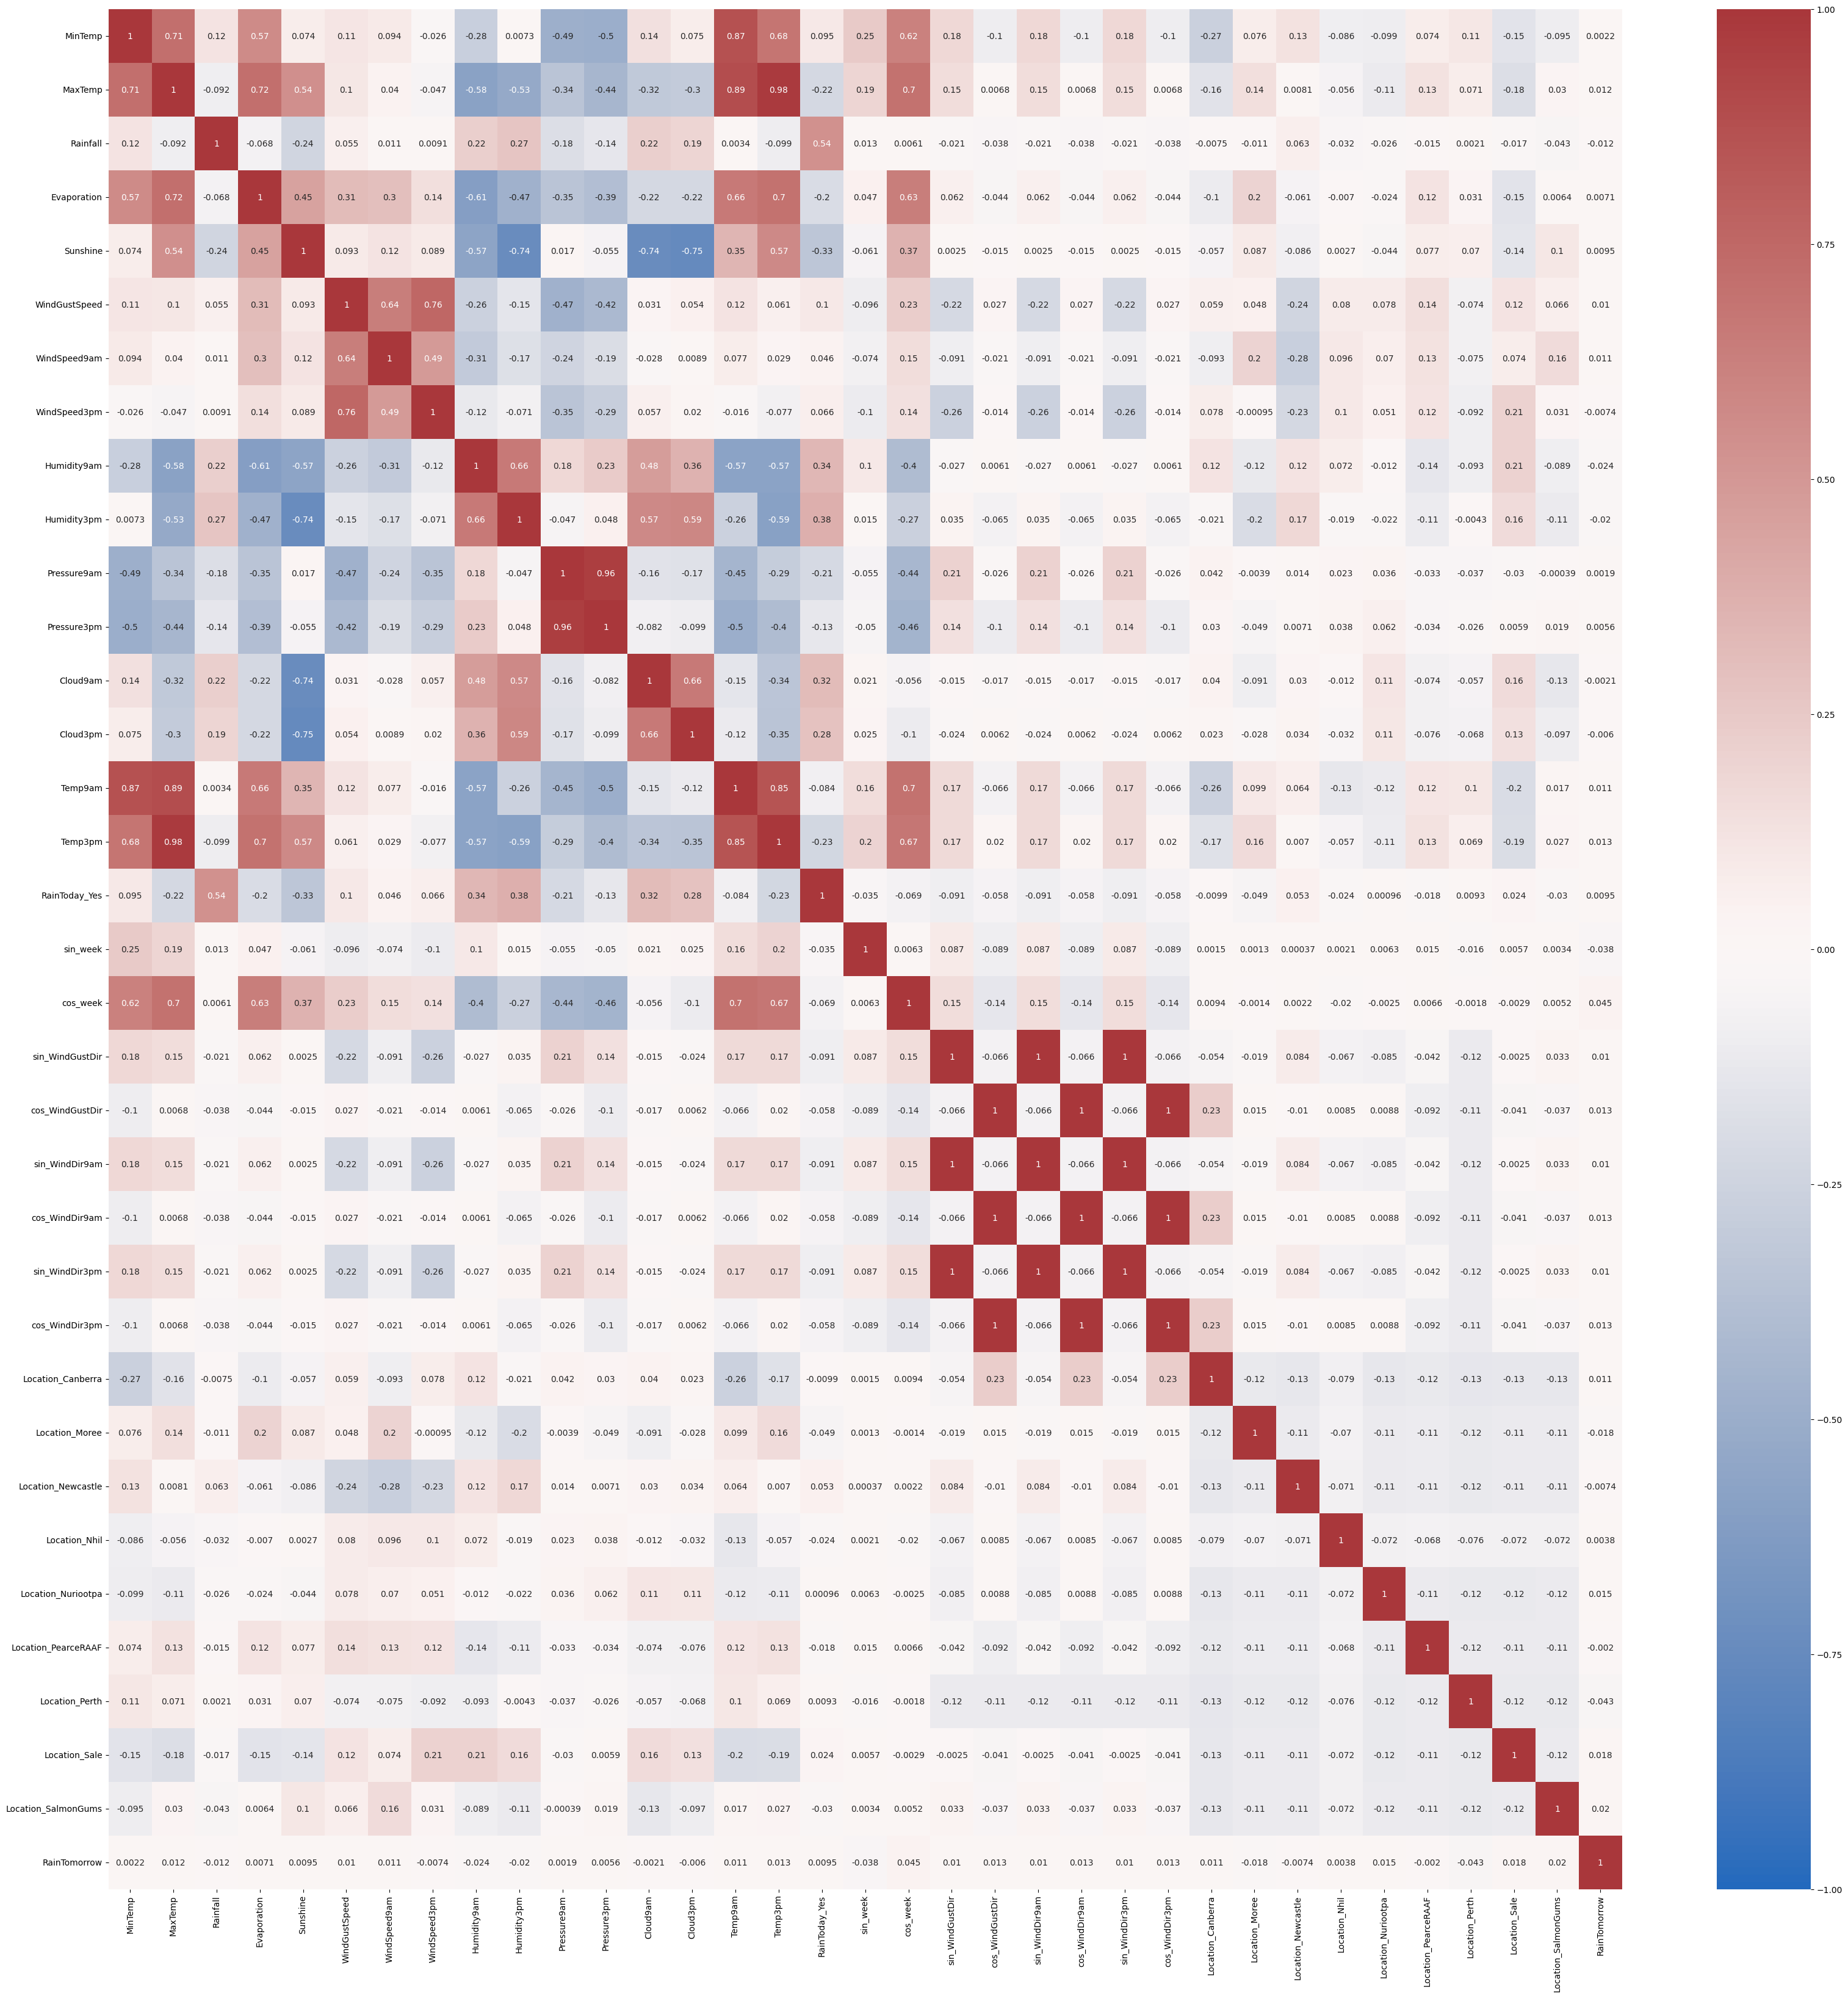

In [34]:
matriz_completa = df_train_completo.corr()

fig, ax = plt.subplots(figsize=(40,40))
sns.heatmap(matriz_completa, annot=True, vmax=1, vmin=-1, cmap='vlag')
plt.show()

En la matriz de correlación de variables de Pearson, podemos observar que hay fuertes relaciones entre:

* Se observa que hay una relación positiva muy alta entre Temp9pm y MaxTemp de (0.89), esta es una correlación que ya podíamos intuir, ya que estamos viendo la relación entre la temperatura en un horario de tarde y la temperatura máxima. También vemos que la relación con MinTemp es de (0.87) por lo mismo, pero en este caso podemos suponer que es menor por el horario donde son medidas estas temperaturas

* Se observa una relación mucho menor entre Temp3pm y MinTemp de (0.68), esto se puede entender por el horario donde son tomados los datos de temperatura, diferente es el caso de la relación con MaxTemp, que es de (0.98) notando que tiene una relación positiva perfecta, esto es correcto si suponemos que la mayor temperatura se da en el rango de a las 3 pm, que es cuando son tomadas estas medidas de temperatura. También se puede observar una relación positiva alta con Evaporation (0.7), esto también podemos notar que está relacionado con una alta correlación de la temperatura máxima (MaxTemp), ya que a mayor temperatura, se espera una mayor evaporación. Además, una relación esperable con Temp9am de (0.86), siendo esta positivamente alta

* Se puede apreciar una relación negativa alta entre Cloud3pm y Sunshine de (-0.75), esto quiere decir que, en el caso de que haya mayor cantidad de nubes, va a ver una menor cantidad de luz solar, esto mismo sucede con Cloud9pm y Sunshine, teniendo también una relación negativa alta de (-0.73)

* Se puede observar una relación positiva casi perfecta entre Pressure3pm y Pressure9am de (0.96), lo que quiere decir que las presiones en distintos horarios suelen ser altamente similares y estar muy relacionadas

* Se puede notar que existe una relación negativa alta entre Humidity3pm y Sunshine de (-0.73), lo que nos da a entender que si nuestra humedad es muy alta es porque tenemos una cantidad muy baja de radiación solar o "Sunshine"


# 2

### Modelo de regresion logistica

In [35]:
modelo_relog =LogisticRegression(class_weight='balanced',random_state=25923)
modelo_relog.fit(x_train_procesado, y_train_codif)
y_probs_relog = modelo_relog.predict_proba(x_test_procesado)[:, 1]

y_pred_relog = modelo_relog.predict(x_test_procesado)


modelo_relog_desba = LogisticRegression(random_state=25923)
modelo_relog_desba.fit(x_train_procesado, y_train_codif)
y_probs_relog_desba = modelo_relog_desba.predict_proba(x_test_procesado)[:, 1]

y_pred_relog_desba = modelo_relog_desba.predict(x_test_procesado)

In [36]:
# Crear las métricas para el modelo balanceado (Llueve y No Llueve)
metrics_balanceado_llueve = {
    'Accuracy': accuracy_score(y_test_codif, y_pred_relog),
    'Precision': precision_score(y_test_codif, y_pred_relog, pos_label=1),
    'Recall': recall_score(y_test_codif, y_pred_relog, pos_label=1),
    'F1': f1_score(y_test_codif, y_pred_relog, pos_label=1),
    'Matthews': matthews_corrcoef(y_test_codif, y_pred_relog),
    'Jaccard': jaccard_score(y_test_codif, y_pred_relog)
}

metrics_balanceado_no_llueve = {
    'Accuracy': accuracy_score(y_test_codif, y_pred_relog),
    'Precision': precision_score(y_test_codif, y_pred_relog, pos_label=0),
    'Recall': recall_score(y_test_codif, y_pred_relog, pos_label=0),
    'F1': f1_score(y_test_codif, y_pred_relog, pos_label=0),
    'Matthews': matthews_corrcoef(y_test_codif, y_pred_relog),
    'Jaccard': jaccard_score(y_test_codif, y_pred_relog)
}

# Crear las métricas para el modelo desbalanceado (Llueve y No Llueve)
metrics_desbalanceado_llueve = {
    'Accuracy': accuracy_score(y_test_codif, y_pred_relog_desba),
    'Precision': precision_score(y_test_codif, y_pred_relog_desba, pos_label=1),
    'Recall': recall_score(y_test_codif, y_pred_relog_desba, pos_label=1),
    'F1': f1_score(y_test_codif, y_pred_relog_desba, pos_label=1),
    'Matthews': matthews_corrcoef(y_test_codif, y_pred_relog_desba),
    'Jaccard': jaccard_score(y_test_codif, y_pred_relog_desba)
}

metrics_desbalanceado_no_llueve = {
    'Accuracy': accuracy_score(y_test_codif, y_pred_relog_desba),
    'Precision': precision_score(y_test_codif, y_pred_relog_desba, pos_label=0),
    'Recall': recall_score(y_test_codif, y_pred_relog_desba, pos_label=0),
    'F1': f1_score(y_test_codif, y_pred_relog_desba, pos_label=0),
    'Matthews': matthews_corrcoef(y_test_codif, y_pred_relog_desba),
    'Jaccard': jaccard_score(y_test_codif, y_pred_relog_desba)
}

# Crear el DataFrame con las métricas para ambas clases y ambos modelos
metricas_relog = pd.DataFrame({
    'Accuracy': [
        metrics_balanceado_llueve['Accuracy'], metrics_balanceado_no_llueve['Accuracy'], 
        metrics_desbalanceado_llueve['Accuracy'], metrics_desbalanceado_no_llueve['Accuracy']
    ],
    'Precision': [
        metrics_desbalanceado_llueve['Precision'], metrics_desbalanceado_no_llueve['Precision'], 
        metrics_balanceado_llueve['Precision'], metrics_balanceado_no_llueve['Precision']
    ],
    'Recall': [
        metrics_balanceado_llueve['Recall'], metrics_balanceado_no_llueve['Recall'], 
        metrics_desbalanceado_llueve['Recall'], metrics_desbalanceado_no_llueve['Recall']
    ],
    'F1': [
        metrics_balanceado_llueve['F1'], metrics_balanceado_no_llueve['F1'], 
        metrics_desbalanceado_llueve['F1'], metrics_desbalanceado_no_llueve['F1']
    ],
    'Matthews': [
        metrics_balanceado_llueve['Matthews'], metrics_balanceado_no_llueve['Matthews'], 
        metrics_desbalanceado_llueve['Matthews'], metrics_desbalanceado_no_llueve['Matthews']
    ],
    'Jaccard': [
        metrics_balanceado_llueve['Jaccard'], metrics_balanceado_no_llueve['Jaccard'], 
        metrics_desbalanceado_llueve['Jaccard'], metrics_desbalanceado_no_llueve['Jaccard']
    ]
}, index=['Balanceado - Llueve', 'Balanceado - No Llueve', 'Desbalanceado - Llueve', 'Desbalanceado - No Llueve'])


metricas_relog


,Accuracy,Precision,Recall,F1,Matthews,Jaccard
Balanceado - Llueve,0.784378,0.735250,0.742287,0.567858,0.456711,0.396510
Balanceado - No Llueve,0.784378,0.879523,0.794307,0.856352,0.456711,0.396510
Desbalanceado - Llueve,0.863007,0.459809,0.441016,0.551333,0.498093,0.380579
Desbalanceado - No Llueve,0.863007,0.928911,0.962543,0.919162,0.498093,0.380579


Explicar cada dato de cada variable


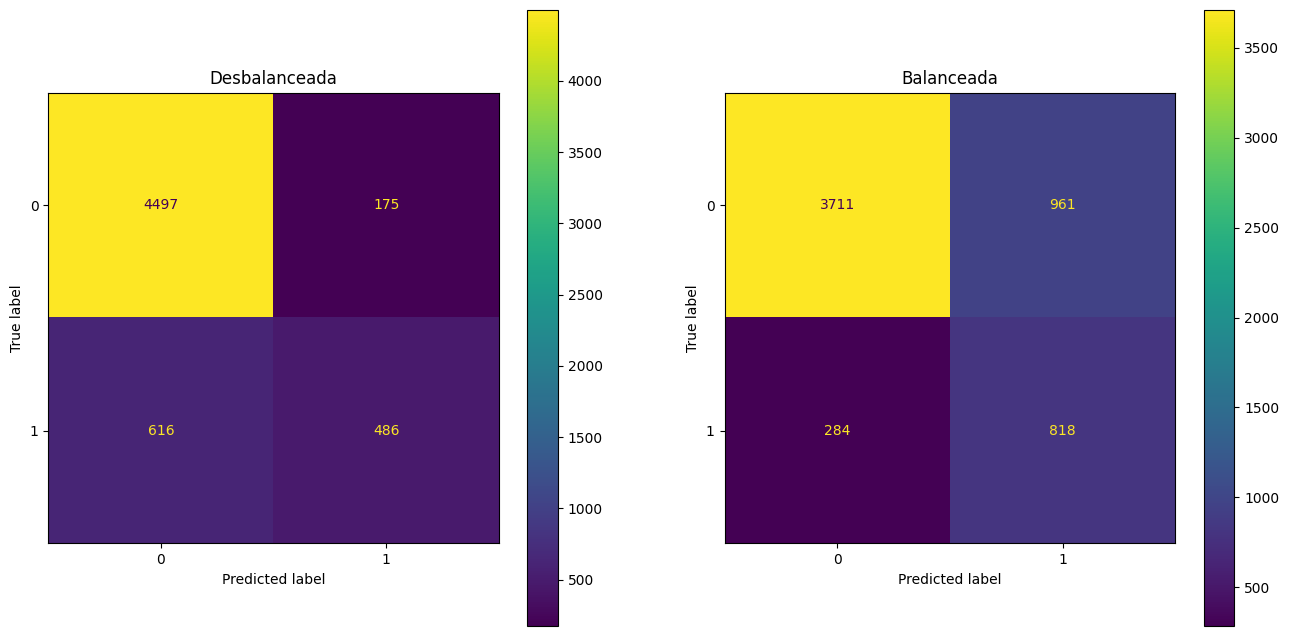

In [37]:
confusion_matrix_relog = confusion_matrix(y_test_codif, y_pred_relog)
confusion_matrix_relog_desba = confusion_matrix(y_test_codif, y_pred_relog_desba)


fig_matrix, axes_matrix = plt.subplots(1,2, figsize = (16, 8))

metrics.ConfusionMatrixDisplay(confusion_matrix= confusion_matrix_relog).plot(ax=axes_matrix[1])
axes_matrix[1].title.set_text('Balanceada')

metrics.ConfusionMatrixDisplay(confusion_matrix= confusion_matrix_relog_desba).plot(ax=axes_matrix[0])
axes_matrix[0].title.set_text('Desbalanceada')

plt.show()

Comentar los numeros de cada bloque

vemos que tenemos mas falsos negativos que falsos positivos, esto puede darse porque el dataset esta desbalanceado, teniendo pocos casos de lluvia.

Los falsos negativos quieren decir que el modelo predice que no iba a llover y llueve
Los falsos positivos quieren decir que el modelo pecide que va a llover y no llueve 

ROC

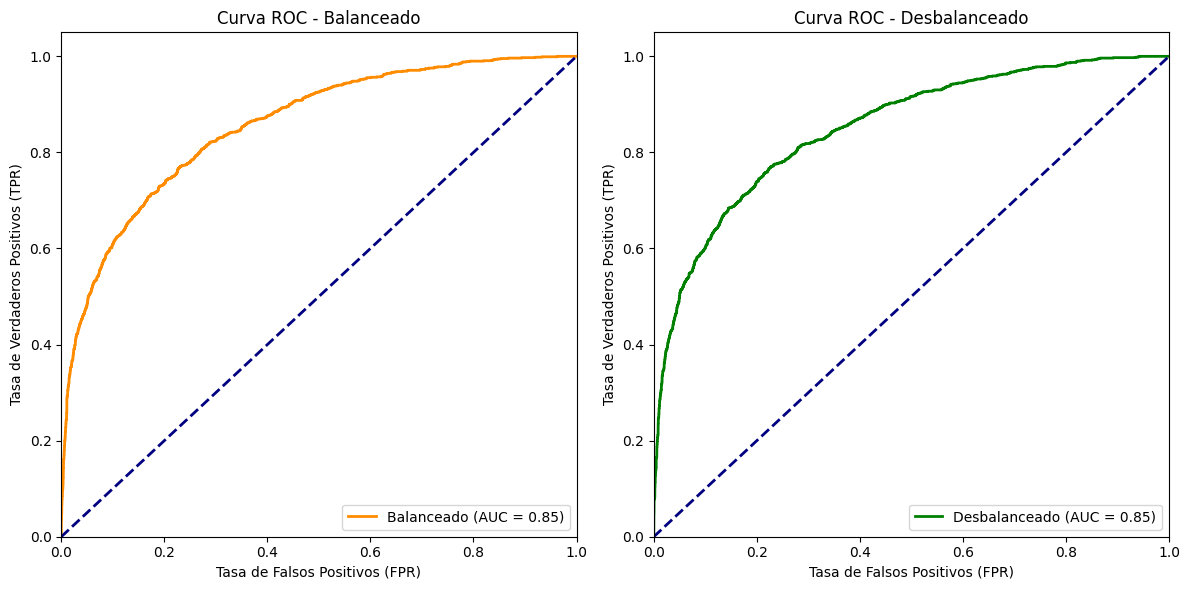

In [38]:
fpr_relog, tpr_relog, thresholds_relog = roc_curve(y_test_codif, y_probs_relog)
roc_auc_relog = auc(fpr_relog, tpr_relog)

# Curva ROC para el modelo desbalanceado
fpr_relog_desba, tpr_relog_desba, thresholds_relog_desba = roc_curve(y_test_codif, y_probs_relog_desba)
roc_auc_relog_desba = auc(fpr_relog_desba, tpr_relog_desba)

# Crear la figura con 2 subplots (1 fila, 2 columnas)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Gráfico para el modelo balanceado
axes[0].plot(fpr_relog, tpr_relog, color='darkorange', lw=2, label='Balanceado (AUC = %0.2f)' % roc_auc_relog)
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('Tasa de Falsos Positivos (FPR)')
axes[0].set_ylabel('Tasa de Verdaderos Positivos (TPR)')
axes[0].set_title('Curva ROC - Balanceado')
axes[0].legend(loc="lower right")

# Gráfico para el modelo desbalanceado
axes[1].plot(fpr_relog_desba, tpr_relog_desba, color='green', lw=2, label='Desbalanceado (AUC = %0.2f)' % roc_auc_relog_desba)
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Tasa de Falsos Positivos (FPR)')
axes[1].set_ylabel('Tasa de Verdaderos Positivos (TPR)')
axes[1].set_title('Curva ROC - Desbalanceado')
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

Explicar las curvas roc

# 3


### Modelo base

Se puede hacer la moda xq es corki corki